In [25]:
# numeric
import numpy as np
from numpy import random
import pandas as pd
import os

In [26]:
import logging
logger = log = logging.getLogger(__name__)
# log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

In [27]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding

In [28]:
from environment.portfolio import PortfolioEnv


In [29]:
# params
window_length = 50
cash_bias = 0.0
batch_size=1


In [30]:
df=pd.read_hdf('Poloniex-30m-2023-07-21.h5')


In [31]:
import gym.spaces
import gym.wrappers
import numpy as np


def concat_states(state):
    history = state["history"]
    weights = state["weights"]
    weight_insert_shape = (history.shape[0], 1, history.shape[2])
    if len(weights) - 1 == history.shape[0]:
        weight_insert = np.ones(
            weight_insert_shape) * weights[1:, np.newaxis, np.newaxis]
    elif len(weights) - 1 == history.shape[2]:
        weight_insert = np.ones(
            weight_insert_shape) * weights[np.newaxis, np.newaxis, 1:]
    else:
        weight_insert = np.ones(
            weight_insert_shape) * weights[np.newaxis, 1:, np.newaxis]
    state = np.concatenate([weight_insert, history], axis=1)
    return state


class ConcatStates(gym.Wrapper):
    """
    Concat both state arrays for models that take a single inputs.

    Usage:
        env = ConcatStates(env)

    """

    def __init__(self, env):
        super().__init__(env)
        hist_space = self.observation_space.spaces["history"]
        hist_shape = hist_space.shape
        self.observation_space = gym.spaces.Box(-10, 10, shape=(
            hist_shape[0], hist_shape[1] + 1, hist_shape[2]))

    def step(self, action):

        state, reward, done, info = self.env.step(action)

        # concat the two state arrays, since some models only take a single output
        state = concat_states(state)

        return state, reward, done, info

    def reset(self):
        self.env.reset()
        state = self.env.reset()
        return concat_states(state)
    

In [32]:
env_specs_args = [

    dict(id='CryptoPortfolioEIIE-v1',
         entry_point='environment.portfolio:PortfolioEnv',
         kwargs=dict(
             steps=1000,
             output_mode='EIIE',
             df=df
         )
         )]
env_specs = [spec['id'] for spec in env_specs_args]

In [33]:
from gym.envs.registration import register
for env_spec_args in env_specs_args:
    register(**env_spec_args)

c:\Users\Lenovo\Anaconda3\envs\finalenv\Lib\site-packages\gym\envs\registration.py:498: UserWarning: WARN: Overriding environment CryptoPortfolioEIIE-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [34]:
env= gym.make('CryptoPortfolioEIIE-v1')
env = ConcatStates(env)

c:\Users\Lenovo\Documents\GitHub\Portfolio_optimisation\portfolioOPT\environment\portfolio.py:95: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="pad")


reseting data
idx:  99942
reseting data
idx:  84903
step:  0


c:\Users\Lenovo\Anaconda3\envs\finalenv\Lib\site-packages\gym\utils\passive_env_checker.py:20: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
c:\Users\Lenovo\Anaconda3\envs\finalenv\Lib\site-packages\gym\utils\passive_env_checker.py:25: UserWarning: WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


In [48]:
import torch
import torch.nn as nn

class DepthCNN(nn.Module):
    def __init__(self, channels, ratio=16 ,bias=True,num_assets=13,hist_len=10,cash_bias_int=0,batch_size=128,device='cpu'):
        super(DepthCNN,self).__init__()
        self.channels = channels
        self.convs1x1 = nn.Conv2d(channels, 6, kernel_size=(1, 1), padding=(0, 0))
        self.convs1x5 = nn.ModuleList([nn.Conv2d(1, 1, kernel_size=(1, 5), padding=(0, 2)) for _ in range(0,6)]).to(device)
        self.convs5x1 = nn.ModuleList([nn.Conv2d(1, 1, kernel_size=(5, 1), padding=(2, 0)) for _ in range(0,6)]).to(device)
        self.ratio = ratio
        self.Cdense1 = nn.Linear(12, 12 * ratio, bias=bias).to(device)
        self.Cdense2 = nn.Linear(12 * ratio,12, bias=bias).to(device)
        self.Hdense1 = nn.Linear(num_assets, num_assets * ratio, bias=bias).to(device)
        self.Hdense2 = nn.Linear(num_assets * ratio, num_assets, bias=bias).to(device)
        self.Wdense1 = nn.Linear(hist_len, hist_len * ratio, bias=bias).to(device)
        self.Wdense2 = nn.Linear(hist_len * ratio, hist_len, bias=bias).to(device)
        self.convs1x1two = nn.Conv2d(13, 1, kernel_size=(1, 1), padding=(0, 0)).to(device)
        self.cash_bias_int = cash_bias_int 
        self.device = device
        self.batch_size = batch_size



    
    def forward(self,inputs,ifstates=1):
        #print parameters
        w0 = inputs[:, :1, :, :1].to(self.device) 
        cash_bias=torch.ones_like(w0[:, :1, :1, :1].to(self.device)) * self.cash_bias_int
        inputs=inputs[:, :, :, 1:].to(self.device)
        x = self.convs1x1(inputs)
        x = torch.relu(x)
        output_channels = np.split(x,x.shape[1], axis=1)
        out = []
        for i in range(0,6):
            layer = self.convs1x5[i](output_channels[i])
            out.append(layer)
            layer = self.convs5x1[i](output_channels[i])
            out.append(layer)
        concatenated = torch.cat(out, dim=1)
        b, c, h, w = concatenated.shape
        C = torch.mean(concatenated, dim=[2, 3])[0]
        C = self.Cdense1(C)
        C= torch.relu(C)
        C = torch.sigmoid(self.Cdense2(C))
        C = C.view(1,c, 1, 1)
        W= torch.mean(concatenated, dim=[1, 2])[0]
        W = self.Wdense1(W)
        W= torch.relu(W)
        W = torch.sigmoid(self.Wdense2(W))
        W = W.view(1, 1, 1, w)
        H = torch.mean(concatenated, dim=[1, 3])[0]
        H = self.Hdense1(H)
        H= torch.relu(H)
        H = torch.sigmoid(self.Hdense2(H))
        H = H.view(1, 1, h, 1)
        concatenated = concatenated * (C + H + W)
        concatenated = torch.mean(concatenated, dim=3,keepdim=True)
        concatenated = torch.cat([concatenated, w0], dim=1)
        concatenated = self.convs1x1two(concatenated)
        concatenated = torch.cat([cash_bias, concatenated], dim=2)
        concatenated = torch.relu(concatenated)
        concatenated = concatenated.view(self.batch_size,14)
        concatenated = torch.softmax(concatenated, dim=1)
                # Print parameters of each convolutional layer
        for named, param in self.named_parameters():
            print(named, param.grad_fn)

        return concatenated


In [50]:
device = torch.device("cpu")
policynet=DepthCNN(3,ratio=16,bias=True,num_assets=13,hist_len=16,device=device,batch_size=batch_size).to(device)

In [51]:
env.action_space

Box(0.0, 1.0, (14,), float32)

In [52]:
env.action_space.sample()

array([0.9103484 , 0.90163493, 0.99107784, 0.854596  , 0.9312845 ,
       0.5673265 , 0.11895388, 0.61739755, 0.3743855 , 0.84345526,
       0.30008718, 0.54600066, 0.9337569 , 0.8344237 ], dtype=float32)

In [53]:
env.observation_space

Box(-10.0, 10.0, (13, 17, 3), float32)

In [54]:
state = env.reset()
state, reward, done,_=env.step(env.action_space.sample())
print(_)

reseting data
idx:  52144
step:  0
reseting data
idx:  143790
step:  0
{'reward': -2.302998054424965e-06, 'log_return': -0.002302998054424965, 'portfolio_value': 0.9976996517879888, 'market_return': 1.0017801812425255, 'rate_of_return': -0.002300348212011194, 'weights_mean': 0.07142857, 'weights_std': 0.03858619, 'cost': 0.0023003482120111584, 'weight_Capital': 0.07986062, 'price_Capital': 1.0, 'weight_BTC_data': 0.036809843, 'price_BTC_data': 1.002360468697235, 'weight_XRP_data': 0.14357299, 'price_XRP_data': 1.0026143572415172, 'weight_LTC_data': 0.04782177, 'price_LTC_data': 1.0011447482119094, 'weight_ETH_data': 0.10451934, 'price_ETH_data': 1.0022603978247495, 'weight_DOGE_data': 0.024097612, 'price_DOGE_data': 1.001566281604017, 'weight_TRX_data': 0.033583544, 'price_TRX_data': 1.0024600575311062, 'weight_MATIC_data': 0.09384623, 'price_MATIC_data': 1.0025520571407633, 'weight_BNB_data': 0.04749481, 'price_BNB_data': 1.0019030663617083, 'weight_DOT_data': 0.033493098, 'price_DOT_

In [85]:
import torch.optim.lr_scheduler as lr_scheduler
import glob
def compute_returns(rewards, gamma):
    running_g = 0
    returns = []
    for r in reversed(rewards):
        running_g = r + gamma * running_g
        returns.insert(0, running_g)
    return returns
        
def train(env, policy, optimizer, gamma, num_episodes):
    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    latest_checkpoint = max(glob.glob(f"checkpoints/checkpoint_*.pt"), key=os.path.getctime, default=None)
    if latest_checkpoint is not None:
        print(f"Loading checkpoint: {latest_checkpoint}")
        policy.load_state_dict(torch.load(latest_checkpoint))
    
    for i in range(num_episodes):
        state = env.reset()
        done = False
        rewards = []        
        while not done:
            action = policy(torch.tensor(state).permute(2,0,1).unsqueeze(0).float())
            state, reward, done, _ = env.step(action.cpu()[0].detach().numpy())
            rewards.append(reward)


        loss=0    
        returns = torch.tensor(compute_returns(rewards, gamma), requires_grad=True)
        loss = -returns.mean() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #scheduler.step()  # Update the learning rate

        
        if i % 10 == 0:
            print(f"Episode {i}, loss: {loss.item()}")
        if i % 200 == 0 and i > 0:
            # Save the model parameters to a file
            checkpoint_path = f"checkpoints/checkpoint_{i}.pt"
            torch.save(policy.state_dict(), checkpoint_path)
        # Define the checkpoint directory

#scheduler = lr_scheduler.StepLR(torch.optim.Adam(policynet.parameters(), lr=0.01), step_size=1000, gamma=0.1)
train(env, policynet, torch.optim.Adam(policynet.parameters(), lr=0.01),1, 4)
env.close()


reseting data
idx:  46955
step:  0
reseting data
idx:  130848
step:  0
convs1x1.weight None
convs1x1.bias None
convs1x5.0.weight None
convs1x5.0.bias None
convs1x5.1.weight None
convs1x5.1.bias None
convs1x5.2.weight None
convs1x5.2.bias None
convs1x5.3.weight None
convs1x5.3.bias None
convs1x5.4.weight None
convs1x5.4.bias None
convs1x5.5.weight None
convs1x5.5.bias None
convs5x1.0.weight None
convs5x1.0.bias None
convs5x1.1.weight None
convs5x1.1.bias None
convs5x1.2.weight None
convs5x1.2.bias None
convs5x1.3.weight None
convs5x1.3.bias None
convs5x1.4.weight None
convs5x1.4.bias None
convs5x1.5.weight None
convs5x1.5.bias None
Cdense1.weight None
Cdense1.bias None
Cdense2.weight None
Cdense2.bias None
Hdense1.weight None
Hdense1.bias None
Hdense2.weight None
Hdense2.bias None
Wdense1.weight None
Wdense1.bias None
Wdense2.weight None
Wdense2.bias None
convs1x1two.weight None
convs1x1two.bias None
tensor([0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714,
       

In [56]:
for param in policynet.parameters():
    print(param.grad_fn)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [57]:
torch.save({
                'model_state_dict': policynet.state_dict(),
                'optimizer_state_dict': torch.optim.Adam(policynet.parameters(), lr=0.01).state_dict(),
            }, "checkpoints/save.pth")

In [58]:
def run(env, policy):
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = policy(torch.tensor(state).permute(2,0,1).to(device).unsqueeze(0).float())
        state, reward, done, _ = env.step(action.cpu().detach().numpy()[0])
        total_reward += reward
        
    return total_reward

reward = run(env, policynet.to(device))
print(f"Total reward: {reward}")

reseting data
idx:  56955
step:  0
reseting data
idx:  43560
step:  0
convs1x1.weight None
convs1x1.bias None
convs1x5.0.weight None
convs1x5.0.bias None
convs1x5.1.weight None
convs1x5.1.bias None
convs1x5.2.weight None
convs1x5.2.bias None
convs1x5.3.weight None
convs1x5.3.bias None
convs1x5.4.weight None
convs1x5.4.bias None
convs1x5.5.weight None
convs1x5.5.bias None
convs5x1.0.weight None
convs5x1.0.bias None
convs5x1.1.weight None
convs5x1.1.bias None
convs5x1.2.weight None
convs5x1.2.bias None
convs5x1.3.weight None
convs5x1.3.bias None
convs5x1.4.weight None
convs5x1.4.bias None
convs5x1.5.weight None
convs5x1.5.bias None
Cdense1.weight None
Cdense1.bias None
Cdense2.weight None
Cdense2.bias None
Hdense1.weight None
Hdense1.bias None
Hdense2.weight None
Hdense2.bias None
Wdense1.weight None
Wdense1.bias None
Wdense2.weight None
Wdense2.bias None
convs1x1two.weight None
convs1x1two.bias None
convs1x1.weight None
convs1x1.bias None
convs1x5.0.weight None
convs1x5.0.bias None
conv

convs1x1.weight None
convs1x1.bias None
convs1x5.0.weight None
convs1x5.0.bias None
convs1x5.1.weight None
convs1x5.1.bias None
convs1x5.2.weight None
convs1x5.2.bias None
convs1x5.3.weight None
convs1x5.3.bias None
convs1x5.4.weight None
convs1x5.4.bias None
convs1x5.5.weight None
convs1x5.5.bias None
convs5x1.0.weight None
convs5x1.0.bias None
convs5x1.1.weight None
convs5x1.1.bias None
convs5x1.2.weight None
convs5x1.2.bias None
convs5x1.3.weight None
convs5x1.3.bias None
convs5x1.4.weight None
convs5x1.4.bias None
convs5x1.5.weight None
convs5x1.5.bias None
Cdense1.weight None
Cdense1.bias None
Cdense2.weight None
Cdense2.bias None
Hdense1.weight None
Hdense1.bias None
Hdense2.weight None
Hdense2.bias None
Wdense1.weight None
Wdense1.bias None
Wdense2.weight None
Wdense2.bias None
convs1x1two.weight None
convs1x1two.bias None
convs1x1.weight None
convs1x1.bias None
convs1x5.0.weight None
convs1x5.0.bias None
convs1x5.1.weight None
convs1x5.1.bias None
convs1x5.2.weight None
convs1x

c:\Users\Lenovo\Documents\GitHub\Portfolio_optimisation\portfolioOPT\callbacks\notebook_plot.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  line.set_ydata(ys[i])


IndexError: list index out of range

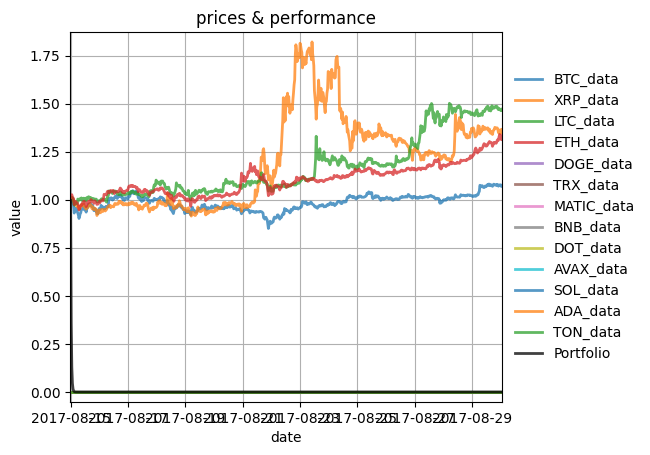

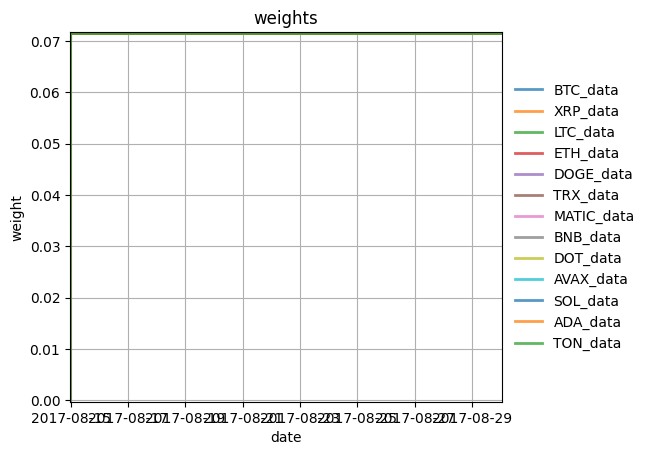

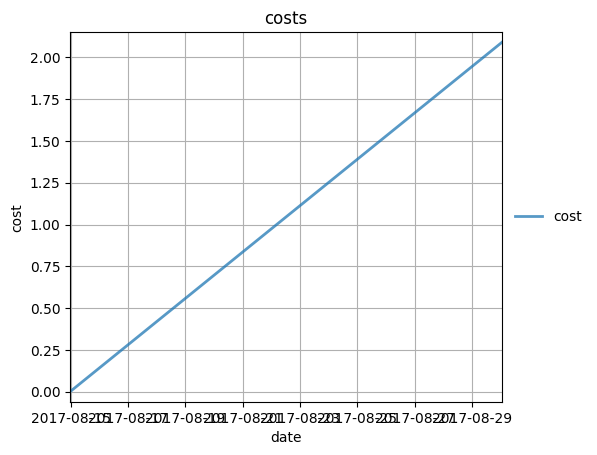

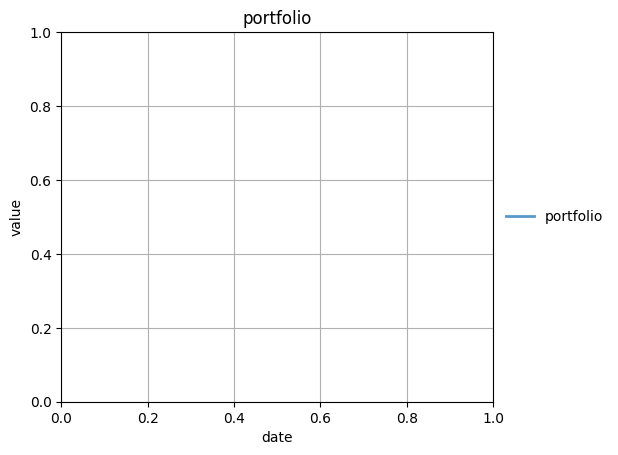

In [59]:
env.plot_notebook()

In [ ]:
from torchinfo import summary

summary(policynet, input_size=(batch_size,3, 13, 17))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []